<a href="https://colab.research.google.com/github/evanss2025/Exploring-Slime-Mold-Inspired-Strategies-for-Improved-Domain-Adaptation-for-Visual-Recognition-in-ML/blob/main/Control_Exploring_Slime_Mold_Inspired_Strategies_for_Improved_Domain_Adaptation_for_Visual_Recognition_in_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Exploring Slime Mold-Inspired Strategies for Improved Domain Adaptation for Visual Recognition in ML**

This code is a part of Sophia Evans's research project. The following creates a domain shift situation in which the SVHN dataset is used to train and validate a classification model, but then the model predicts on the MNIST dataset. This creates domain shift as although both are number datasets, the SVHN dataset introduces new lighting and features that the MNIST dataset does not have, limiting it's efficiency.

Importing libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

Downloading the SVHN dataset. The dataset is downloaded from tensorflow's datasets and the appropriate feautres are extracted from it.

In [ ]:
# Load SVHN dataset
svhn_builder = tfds.builder('svhn_cropped')
svhn_builder.download_and_prepare()
svhn_dataset = tfds.load('svhn_cropped', split='train', as_supervised=True)
svhn_dataset = tfds.as_numpy(svhn_dataset)

# Extract features and labels from SVHN dataset
x_svhn = np.array([tf.image.rgb_to_grayscale(sample[0]).numpy().astype('float32') / 255 for sample in svhn_dataset])
y_svhn = np.array([sample[1] for sample in svhn_dataset])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/73257 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteGUGRF5/svhn_cropped-train.tfrecord*...:   0%|…

Generating test examples...:   0%|          | 0/26032 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteGUGRF5/svhn_cropped-test.tfrecord*...:   0%| …

Generating extra examples...:   0%|          | 0/531131 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/svhn_cropped/3.0.0.incompleteGUGRF5/svhn_cropped-extra.tfrecord*...:   0%|…

Dataset svhn_cropped downloaded and prepared to /root/tensorflow_datasets/svhn_cropped/3.0.0. Subsequent calls will reuse this data.


Preprocessing the SVHN dataset

In [ ]:
# Split data into train and test sets for the source domain (SVHN)
source_train_data, source_test_data, y_svhn_train, y_svhn_test = train_test_split(
    x_svhn, y_svhn, test_size=0.2, random_state=42, shuffle=True
)
# Ensure target labels have the same shape as source labels
y_svhn_train = tf.keras.utils.to_categorical(y_svhn_train, num_classes=10)
y_svhn_test = tf.keras.utils.to_categorical(y_svhn_test, num_classes=10)

Loading the MNIST dataset from Keras, and then preprocessing the dataset.

In [ ]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_mnist, y_mnist), (_, _) = mnist.load_data()

# Resize MNIST images to 32x32 pixels
x_mnist_resized = tf.image.resize(x_mnist[..., tf.newaxis], (32, 32))
x_mnist_resized = tf.squeeze(x_mnist_resized)

# Preprocess MNIST data
x_mnist_resized = x_mnist_resized.numpy()  # Convert to NumPy array
x_mnist_resized = x_mnist_resized.reshape((x_mnist_resized.shape[0], 32, 32, 1)).astype('float32') / 255
y_mnist = tf.keras.utils.to_categorical(y_mnist, num_classes=10)

# Split data into train and test sets for the target domain (MNIST)
target_train_data, target_test_data, target_train_labels, target_test_labels = train_test_split(
    x_mnist_resized, y_mnist, test_size=0.2, random_state=42
)

11490434/11490434 [==============================] - 0s 0us/step


Visualizing an example from each dataset ensuring that they are both the same size and are compatible.

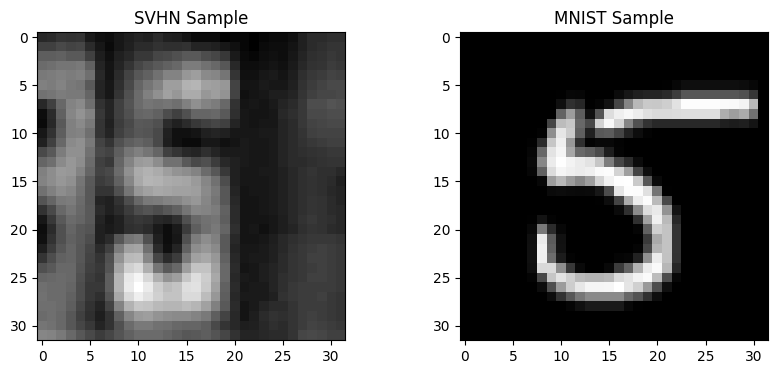

In [ ]:
# Visualize an example image from each dataset
plt.figure(figsize=(10, 4))

# SVHN
plt.subplot(1, 2, 1)
plt.imshow(source_train_data[0].reshape(32, 32), cmap='gray')
plt.title('SVHN Sample')

# MNIST
plt.subplot(1, 2, 2)
plt.imshow(target_train_data[0], cmap='gray')
plt.title('MNIST Sample')

plt.show()

Defining the model architecture, compiling the model, and then train the model on the SVHN dataset

---



In [ ]:
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(128, activation='relu'))

# Output layer
model.add(layers.Dense(10, activation='softmax'))

# Display the model summary
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train on the source domain
model.fit(source_train_data, y_svhn_train, epochs=10, validation_data=(source_test_data, y_svhn_test), batch_size=32)

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_66 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_66 (MaxPooli  (None, 15, 15, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_67 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_67 (MaxPooli  (None, 6, 6, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_68 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_68 (MaxPooli  (None, 2, 2, 128)       

The SVHN trained model predicts on the MNIST dataset and outputs the accuracy and F1-score

In [ ]:
# Evaluate on the target domain
target_predictions = model.predict(target_test_data)
target_accuracy = accuracy_score(np.argmax(target_test_labels, axis=1), np.argmax(target_predictions, axis=1))
target_f1_score = f1_score(np.argmax(target_test_labels, axis=1), np.argmax(target_predictions, axis=1), average='weighted')

print(f"Target Domain Accuracy: {target_accuracy}")
print(f"Target Domain F1 Score: {target_f1_score}")

375/375 [==============================] - 3s 9ms/step
Target Domain Accuracy: 0.5815833333333333
Target Domain F1 Score: 0.5682909747058252
